In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 42

2023-01-16 22:29:45.103323: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 22:29:45.263926: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-16 22:29:46.028780: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-16 22:29:46.028876: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1, color="black")
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2, linestyle='dashed', color="grey")   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [3]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [4]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_final")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_final"] = params["trials_final"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        if init != None:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(n_units, activation=activation,
                            kernel_regularizer=reg, bias_regularizer=reg))

        
        
    if task == "classification":
        
        if init != None:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer=init))
        else:
            model.add(Dense(output_size, activation="sigmoid",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        
        if init != None:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg,
                            kernel_initializer = init, bias_initializer = init))
        else:
            model.add(Dense(output_size, activation="linear",
                            kernel_regularizer=reg, bias_regularizer=reg))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"\nMedian val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_final"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_final"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)
            
            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)
            

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    
    
    print(f"\nMedian model train_loss: {train_loss[-1]}")
    print(f"Median model val_loss: {val_loss[-1]}")
    
    print(f"\nMedian model train_{train_metric}: {train_acc[-1]}")
    print(f"Median model {val_metric}: {val_acc[-1]}")
    
    
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {val_metric}")
    
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    
    return med_model    
    

def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# Monks 1

In [5]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [6]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5,
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.6, 0.7, 0.8, 0.9],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


  0%|                                                     | 0/1 [00:00<?, ?it/s]2023-01-16 14:22:38.119655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 14:22:39.342703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-16 14:22:39.342774: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-16 14:22:39.359738: I tensorflow/core/platform/cpu_feature_guard.cc:193] Thi

Fold 1/4 median val_loss: 0.0017250098753720522, std val_loss 0.0
Fold 1/4 median train_loss: 0.0002660175960045308, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.64s/it]


Fold 2/4 median val_loss: 0.043050553649663925, std val_loss 0.0
Fold 2/4 median train_loss: 0.0002951947972178459, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.49s/it]


Fold 3/4 median val_loss: 0.0002726333914324641, std val_loss 0.0
Fold 3/4 median train_loss: 0.00018493563402444124, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.94s/it]


Fold 4/4 median val_loss: 0.001736205886118114, std val_loss 0.0
Fold 4/4 median train_loss: 0.00018526901840232313, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011696100700646639, std val_loss: 0.01811228507159692
Mean train_loss: 0.00023285426141228527, std train_loss: 4.88536062355017e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 2/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Fold 1/4 median val_loss: 0.0014847326092422009, std val_loss 0.0
Fold 1/4 median train_loss: 0.0001457393227610737, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.35s/it]


Fold 2/4 median val_loss: 0.0013035297160968184, std val_loss 0.0
Fold 2/4 median train_loss: 0.00014132286014501005, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.44s/it]


Fold 3/4 median val_loss: 0.0003617746406234801, std val_loss 0.0
Fold 3/4 median train_loss: 9.445841715205461e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Fold 4/4 median val_loss: 0.2800542712211609, std val_loss 0.0
Fold 4/4 median train_loss: 0.08572223782539368, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.6451612710952759, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9139785170555115, train_accuracy 0.0

Mean val_loss: 0.07080107704678085, std val_loss: 0.12081314010364419
Mean train_loss: 0.021525939606362954, std train_loss: 0.037063755505007116
Mean val_accuracy: 0.911290317773819, std val_accuracy: 0.15364967673903535
Mean train_accuracy: 0.911290317773819, std train_accuracy: 0.03724839475056844



Testing configuration 3/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.51s/it]


Fold 1/4 median val_loss: 0.05254553630948067, std val_loss 0.0
Fold 1/4 median train_loss: 7.239779370138422e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Fold 2/4 median val_loss: 9.541141480440274e-05, std val_loss 0.0
Fold 2/4 median train_loss: 5.1181752496631816e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Fold 3/4 median val_loss: 0.006925585679709911, std val_loss 0.0
Fold 3/4 median train_loss: 7.091415318427607e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.07s/it]


Fold 4/4 median val_loss: 0.005090504419058561, std val_loss 0.0
Fold 4/4 median train_loss: 5.36747720616404e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.016164259455763386, std val_loss: 0.021152933169087566
Mean train_loss: 6.204211786098313e-05, std train_loss: 9.668415646606798e-06
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 4/16:
{'batch_size': None, 'learning_rate': 0.6, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.86s/it]


Fold 1/4 median val_loss: 0.001481477404013276, std val_loss 0.0
Fold 1/4 median train_loss: 2.0781484636245295e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.60s/it]


Fold 2/4 median val_loss: 0.00018391128105577081, std val_loss 0.0
Fold 2/4 median train_loss: 5.719848923035897e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


Fold 3/4 median val_loss: 0.059511009603738785, std val_loss 0.0
Fold 3/4 median train_loss: 2.5374034521519206e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.36s/it]


Fold 4/4 median val_loss: 0.21796251833438873, std val_loss 0.0
Fold 4/4 median train_loss: 0.02692391723394394, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.06978472915579914, std val_loss: 0.08884229646962921
Mean train_loss: 0.006756817810583016, std train_loss: 0.0116434887265106
Mean val_accuracy: 0.9193548411130905, std val_accuracy: 0.10576513433669522
Mean train_accuracy: 0.9193548411130905, std train_accuracy: 0.01396816416244334



Testing configuration 5/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'un

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.77s/it]


Fold 1/4 median val_loss: 0.0011583770392462611, std val_loss 0.0
Fold 1/4 median train_loss: 0.00013204450078774244, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.70s/it]


Fold 2/4 median val_loss: 0.00585560780018568, std val_loss 0.0
Fold 2/4 median train_loss: 0.00012998914462514222, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Fold 3/4 median val_loss: 0.053661003708839417, std val_loss 0.0
Fold 3/4 median train_loss: 0.0007938465569168329, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.92s/it]


Fold 4/4 median val_loss: 0.10829656571149826, std val_loss 0.0
Fold 4/4 median train_loss: 0.05417201668024063, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9462365508079529, train_accuracy 0.0

Mean val_loss: 0.042242888564942405, std val_loss: 0.04331695080098269
Mean train_loss: 0.013806974220642587, std train_loss: 0.02330633909460123
Mean val_accuracy: 0.9516129046678543, std val_accuracy: 0.053493946637294815
Mean train_accuracy: 0.9516129046678543, std train_accuracy: 0.023280256397693377



Testing configuration 6/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu',

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.44s/it]


Fold 1/4 median val_loss: 0.006028773263096809, std val_loss 0.0
Fold 1/4 median train_loss: 8.665989298606291e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Fold 2/4 median val_loss: 0.002323826076462865, std val_loss 0.0
Fold 2/4 median train_loss: 8.481826807837933e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.87s/it]


Fold 3/4 median val_loss: 0.040117885917425156, std val_loss 0.0
Fold 3/4 median train_loss: 0.00011175538384122774, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.77s/it]


Fold 4/4 median val_loss: 0.0004035548772662878, std val_loss 0.0
Fold 4/4 median train_loss: 9.140088513959199e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.01221851003356278, std val_loss: 0.016234114943175122
Mean train_loss: 9.36586075113155e-05, std train_loss: 1.0720590353825675e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 7/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.52s/it]


Fold 1/4 median val_loss: 0.1837870478630066, std val_loss 0.0
Fold 1/4 median train_loss: 0.0317237488925457, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.774193525314331, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9784946441650391, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.58s/it]


Fold 2/4 median val_loss: 0.00012942896864842623, std val_loss 0.0
Fold 2/4 median train_loss: 6.60749283269979e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.14s/it]


Fold 3/4 median val_loss: 0.0037259175442159176, std val_loss 0.0
Fold 3/4 median train_loss: 0.00011400235234759748, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.30s/it]


Fold 4/4 median val_loss: 0.0749363973736763, std val_loss 0.0
Fold 4/4 median train_loss: 0.0001101312882383354, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.06564469793738681, std val_loss: 0.07444819735525131
Mean train_loss: 0.008003489365364658, std train_loss: 0.01369491116295043
Mean val_accuracy: 0.9193548262119293, std val_accuracy: 0.09265424644296927
Mean train_accuracy: 0.9193548262119293, std train_accuracy: 0.00931209223525004



Testing configuration 8/16:
{'batch_size': None, 'learning_rate': 0.7, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

E

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Fold 1/4 median val_loss: 0.09738705307245255, std val_loss 0.0
Fold 1/4 median train_loss: 0.01081135030835867, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9892473220825195, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 2/4 median val_loss: 0.04146838188171387, std val_loss 0.0
Fold 2/4 median train_loss: 0.0006531337276101112, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.13s/it]


Fold 3/4 median val_loss: 0.01982751116156578, std val_loss 0.0
Fold 3/4 median train_loss: 4.786519275512546e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Fold 4/4 median val_loss: 0.0012937473366037011, std val_loss 0.0
Fold 4/4 median train_loss: 1.911618164740503e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.039994173363083974, std val_loss: 0.03605736114537386
Mean train_loss: 0.0028828663525928278, std train_loss: 0.004584508207911175
Mean val_accuracy: 0.9596773982048035, std val_accuracy: 0.03515241833378536
Mean train_accuracy: 0.9596773982048035, std train_accuracy: 0.00465604611762502



Testing configuration 9/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.83s/it]


Fold 1/4 median val_loss: 0.0003264212282374501, std val_loss 0.0
Fold 1/4 median train_loss: 0.00010705140448408201, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.83s/it]


Fold 2/4 median val_loss: 0.012450513429939747, std val_loss 0.0
Fold 2/4 median train_loss: 0.0001278339623240754, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Fold 3/4 median val_loss: 0.012139441445469856, std val_loss 0.0
Fold 3/4 median train_loss: 0.00019063387298956513, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Fold 4/4 median val_loss: 0.16149941086769104, std val_loss 0.0
Fold 4/4 median train_loss: 0.03233453258872032, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8387096524238586, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9677419066429138, train_accuracy 0.0

Mean val_loss: 0.04660394674283452, std val_loss: 0.06651472802445862
Mean train_loss: 0.008190012957129511, std train_loss: 0.013939878869433155
Mean val_accuracy: 0.9516128897666931, std val_accuracy: 0.06650171249927743
Mean train_accuracy: 0.9516128897666931, std train_accuracy: 0.01396816416244334



Testing configuration 10/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.34s/it]


Fold 1/4 median val_loss: 0.0014220093144103885, std val_loss 0.0
Fold 1/4 median train_loss: 0.00016106107796076685, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Fold 2/4 median val_loss: 0.0011194561375305057, std val_loss 0.0
Fold 2/4 median train_loss: 8.031161269173026e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Fold 3/4 median val_loss: 0.0019581501837819815, std val_loss 0.0
Fold 3/4 median train_loss: 0.00015159514441620559, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.89s/it]


Fold 4/4 median val_loss: 0.0022762382868677378, std val_loss 0.0
Fold 4/4 median train_loss: 8.076436643023044e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0016939634806476533, std val_loss: 0.00045079272395995713
Mean train_loss: 0.00011843305037473328, std train_loss: 3.804289348295231e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 11/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.30s/it]


Fold 1/4 median val_loss: 0.00673337047919631, std val_loss 0.0
Fold 1/4 median train_loss: 8.858797082211822e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Fold 2/4 median val_loss: 0.00012991155381314456, std val_loss 0.0
Fold 2/4 median train_loss: 4.1031304135685787e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.66s/it]


Fold 3/4 median val_loss: 0.0006069529918022454, std val_loss 0.0
Fold 3/4 median train_loss: 3.6707668186863884e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.61s/it]


Fold 4/4 median val_loss: 0.0401175320148468, std val_loss 0.0
Fold 4/4 median train_loss: 0.0001267580664716661, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.011896941759914625, std val_loss: 0.01649993203746034
Mean train_loss: 7.32712524040835e-05, std train_loss: 3.698564281365199e-05
Mean val_accuracy: 0.9838709682226181, std val_accuracy: 0.0279363025153184
Mean train_accuracy: 0.9838709682226181, std train_accuracy: 0.0



Testing configuration 12/16:
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


Fold 1/4 median val_loss: 0.24419890344142914, std val_loss 0.0
Fold 1/4 median train_loss: 0.055460959672927856, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.6774193644523621, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9462365508079529, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.53s/it]


Fold 2/4 median val_loss: 0.0583084411919117, std val_loss 0.0
Fold 2/4 median train_loss: 0.0003754270146600902, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Fold 3/4 median val_loss: 4.569083466776647e-05, std val_loss 0.0
Fold 3/4 median train_loss: 9.838558980845846e-06, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Fold 4/4 median val_loss: 0.0003886861668433994, std val_loss 0.0
Fold 4/4 median train_loss: 3.64227598765865e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.075735430408713, std val_loss: 0.10011207500102533
Mean train_loss: 0.013970662001611345, std train_loss: 0.023954868135971225
Mean val_accuracy: 0.9032258093357086, std val_accuracy: 0.13300340331417862
Mean train_accuracy: 0.9032258093357086, std train_accuracy: 0.023280256397693377



Testing configuration 13/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fol

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


Fold 1/4 median val_loss: 0.004195082001388073, std val_loss 0.0
Fold 1/4 median train_loss: 8.462071127723902e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


Fold 2/4 median val_loss: 0.004024357534945011, std val_loss 0.0
Fold 2/4 median train_loss: 8.879557572072372e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.06s/it]


Fold 3/4 median val_loss: 0.0014488056767731905, std val_loss 0.0
Fold 3/4 median train_loss: 7.199563697213307e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.94s/it]


Fold 4/4 median val_loss: 0.012386263348162174, std val_loss 0.0
Fold 4/4 median train_loss: 0.0005188912618905306, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.005513627140317112, std val_loss: 0.004114376842753616
Mean train_loss: 0.0001910757964651566, std train_loss: 0.00018936538257746267
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


Fold 1/4 median val_loss: 0.02056081034243107, std val_loss 0.0
Fold 1/4 median train_loss: 7.87013050285168e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Fold 2/4 median val_loss: 0.0004155279020778835, std val_loss 0.0
Fold 2/4 median train_loss: 8.858826186042279e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Fold 3/4 median val_loss: 0.004120517522096634, std val_loss 0.0
Fold 3/4 median train_loss: 6.527927325805649e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


Fold 4/4 median val_loss: 0.006809886544942856, std val_loss 0.0
Fold 4/4 median train_loss: 5.984746530884877e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00797668557788711, std val_loss: 0.007611878111639661
Mean train_loss: 7.310407636396121e-05, std train_loss: 1.1270029386883374e-05
Mean val_accuracy: 0.9919354766607285, std val_accuracy: 0.01396816416244334
Mean train_accuracy: 0.9919354766607285, std train_accuracy: 0.0



Testing configuration 15/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.01s/it]


Fold 1/4 median val_loss: 0.0007153854821808636, std val_loss 0.0
Fold 1/4 median train_loss: 3.07513473671861e-05, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


Fold 2/4 median val_loss: 0.0004466382961254567, std val_loss 0.0
Fold 2/4 median train_loss: 3.391622885828838e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Fold 3/4 median val_loss: 0.0011012020986527205, std val_loss 0.0
Fold 3/4 median train_loss: 3.669817670015618e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.60s/it]


Fold 4/4 median val_loss: 0.13644589483737946, std val_loss 0.0
Fold 4/4 median train_loss: 0.04304360970854759, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9569892287254333, train_accuracy 0.0

Mean val_loss: 0.034677280178584624, std val_loss: 0.058756597680291914
Mean train_loss: 0.010786243865368306, std train_loss: 0.018623798971753244
Mean val_accuracy: 0.9677419364452362, std val_accuracy: 0.0558726050306368
Mean train_accuracy: 0.9677419364452362, std train_accuracy: 0.01862421028006836



Testing configuration 16/16:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu',

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Fold 1/4 median val_loss: 0.08286318182945251, std val_loss 0.0
Fold 1/4 median train_loss: 0.06452835351228714, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9354838728904724, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.84s/it]


Fold 2/4 median val_loss: 0.006897402927279472, std val_loss 0.0
Fold 2/4 median train_loss: 0.0011396321933716536, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.10s/it]


Fold 3/4 median val_loss: 0.06923259794712067, std val_loss 0.0
Fold 3/4 median train_loss: 1.9178101865691133e-05, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Fold 4/4 median val_loss: 0.06473199278116226, std val_loss 0.0
Fold 4/4 median train_loss: 0.06452551484107971, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9354838728904724, train_accuracy 0.0

Mean val_loss: 0.05593129387125373, std val_loss: 0.029086191060020528
Mean train_loss: 0.03255316966215105, std train_loss: 0.03197621843510304
Mean val_accuracy: 0.9354838579893112, std val_accuracy: 0.03950791006646899
Mean train_accuracy: 0.9354838579893112, std train_accuracy: 0.032258063554763794






Best configuration (loss 0.0016939634806476533):
{'batch_size': None, 'learning_rate': 0.8, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'a

 20%|█████████                                    | 1/5 [00:07<00:31,  7.81s/it]

Trial 1/5 val_mse: 0.0037196108605712652
Trial 1/5 train_mse: 0.00011136515240650624
Trial 1/5 val_accuracy: 1.0
Trial 1/5 train_accuracy: 1.0


 40%|██████████████████                           | 2/5 [00:18<00:27,  9.32s/it]

Trial 2/5 val_mse: 0.006991926580667496
Trial 2/5 train_mse: 0.00020964867144357413
Trial 2/5 val_accuracy: 1.0
Trial 2/5 train_accuracy: 1.0


 60%|███████████████████████████                  | 3/5 [00:33<00:23, 11.85s/it]

Trial 3/5 val_mse: 0.017566213384270668
Trial 3/5 train_mse: 4.794840788235888e-05
Trial 3/5 val_accuracy: 0.9599999785423279
Trial 3/5 train_accuracy: 1.0


 80%|████████████████████████████████████         | 4/5 [00:47<00:12, 12.76s/it]

Trial 4/5 val_mse: 0.0026758986059576273
Trial 4/5 train_mse: 3.9021535485517234e-05
Trial 4/5 val_accuracy: 1.0
Trial 4/5 train_accuracy: 1.0


100%|█████████████████████████████████████████████| 5/5 [00:49<00:00,  9.83s/it]

Trial 5/5 val_mse: 0.07582193613052368
Trial 5/5 train_mse: 0.001119457301683724
Trial 5/5 val_accuracy: 0.8399999737739563
Trial 5/5 train_accuracy: 1.0

Median val_mse: 0.006991926580667496, std val_mse: 0.027738838088264012
Median train_mse: 0.00020964867144357413, std train_mse: 0.0004115205703626935
Median val_accuracy: 1.0, std val_accuracy: 0.06196774369662201
Median train_accuracy: 1.0, std train_accuracy: 0.0

Median model train_loss: 0.00020964867144357413
Median model val_loss: 0.006991926580667496

Median model train_accuracy: 1.0
Median model val_accuracy: 1.0


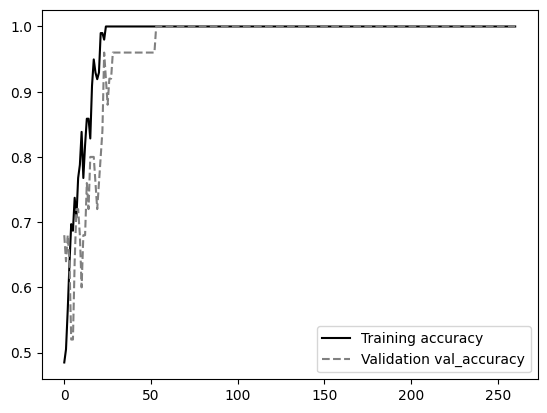

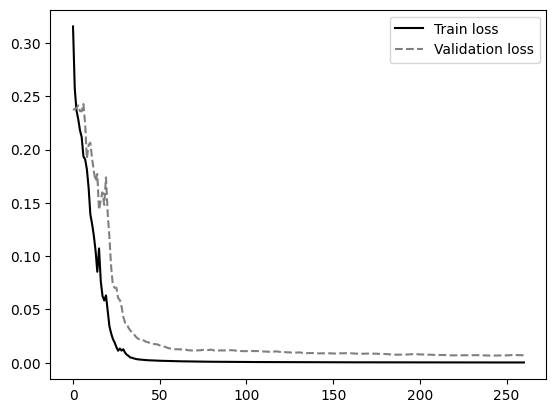

In [7]:
model = grid_search(params, x_train, y_train, k_fold_val)

In [8]:
test_model(model, x_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.0040 - accuracy: 1.0000
[0.004028249531984329, 1.0]


# Monks 2

In [5]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [10]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default"
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.1, 0.2],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.6, 0.7, 0.8, 0.9],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/8:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Fold 1/4 median val_loss: 0.2691255807876587, std val_loss 0.0
Fold 1/4 median train_loss: 0.22246699035167694, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.4883720874786377, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6507936716079712, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]


Fold 2/4 median val_loss: 0.23660552501678467, std val_loss 0.0
Fold 2/4 median train_loss: 0.21519602835178375, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6692913174629211, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.86s/it]


Fold 3/4 median val_loss: 0.005386923439800739, std val_loss 0.0
Fold 3/4 median train_loss: 0.0015361594269052148, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]


Fold 4/4 median val_loss: 0.2824179232120514, std val_loss 0.0
Fold 4/4 median train_loss: 0.19905638694763184, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.4523809552192688, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.7007874250411987, train_accuracy 0.0

Mean val_loss: 0.19838398811407387, std val_loss: 0.11266635260597697
Mean train_loss: 0.15956389126949944, std train_loss: 0.0916299020471572
Mean val_accuracy: 0.6399501711130142, std val_accuracy: 0.2169279380372722
Mean train_accuracy: 0.6399501711130142, std train_accuracy: 0.1424506494775094



Testing configuration 2/8:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Fold 1/4 median val_loss: 0.25320327281951904, std val_loss 0.0
Fold 1/4 median train_loss: 0.21792148053646088, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5581395626068115, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.6428571343421936, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.14s/it]


Fold 2/4 median val_loss: 0.000884375418536365, std val_loss 0.0
Fold 2/4 median train_loss: 0.0008034201455302536, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.95s/it]


Fold 3/4 median val_loss: 0.2564273178577423, std val_loss 0.0
Fold 3/4 median train_loss: 0.1927170306444168, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.6428571343421936, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.7244094610214233, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.65s/it]


Fold 4/4 median val_loss: 0.237535297870636, std val_loss 0.0
Fold 4/4 median train_loss: 0.2221602201461792, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.5714285969734192, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6299212574958801, train_accuracy 0.0

Mean val_loss: 0.18701256599160843, std val_loss: 0.10769849953636923
Mean train_loss: 0.15840053786814678, std train_loss: 0.09168221323034859
Mean val_accuracy: 0.6931063234806061, std val_accuracy: 0.1800903976933391
Mean train_accuracy: 0.6931063234806061, std train_accuracy: 0.1492074032220474



Testing configuration 3/8:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.13s/it]


Fold 1/4 median val_loss: 0.3006944954395294, std val_loss 0.0
Fold 1/4 median train_loss: 0.19107688963413239, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5348837375640869, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.7460317611694336, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.13s/it]


Fold 2/4 median val_loss: 0.0008642449975013733, std val_loss 0.0
Fold 2/4 median train_loss: 0.00044746490311808884, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


Fold 3/4 median val_loss: 0.21659569442272186, std val_loss 0.0
Fold 3/4 median train_loss: 0.1970657855272293, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.6190476417541504, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.7086614370346069, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.32s/it]


Fold 4/4 median val_loss: 0.0012670281575992703, std val_loss 0.0
Fold 4/4 median train_loss: 0.00047538484795950353, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.12985536575433798, std val_loss: 0.1321774968074091
Mean train_loss: 0.09726638122810982, std train_loss: 0.09682811074845925
Mean val_accuracy: 0.7884828448295593, std val_accuracy: 0.21359998192289378
Mean train_accuracy: 0.7884828448295593, std train_accuracy: 0.13696545876990798



Testing configuration 4/8:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.36s/it]


Fold 1/4 median val_loss: 0.0001887796533992514, std val_loss 0.0
Fold 1/4 median train_loss: 0.00015793646161910146, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.86s/it]


Fold 2/4 median val_loss: 0.0006856520194560289, std val_loss 0.0
Fold 2/4 median train_loss: 0.0001902626536320895, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.50s/it]


Fold 3/4 median val_loss: 0.000489254598505795, std val_loss 0.0
Fold 3/4 median train_loss: 0.00019775993132498115, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:23<00:00, 23.05s/it]


Fold 4/4 median val_loss: 0.0004470676649361849, std val_loss 0.0
Fold 4/4 median train_loss: 0.00017614595708437264, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00045268848407431506, std val_loss: 0.00017698061621137083
Mean train_loss: 0.0001805262509151362, std train_loss: 1.517632064120319e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 5/8:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:41<00:00, 41.46s/it]


Fold 1/4 median val_loss: 0.0007663372671231627, std val_loss 0.0
Fold 1/4 median train_loss: 0.00045990943908691406, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.89s/it]


Fold 2/4 median val_loss: 0.0020577034447342157, std val_loss 0.0
Fold 2/4 median train_loss: 0.00048053465434350073, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.44s/it]


Fold 3/4 median val_loss: 0.0007282146834768355, std val_loss 0.0
Fold 3/4 median train_loss: 0.00042875175131484866, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.52s/it]


Fold 4/4 median val_loss: 0.00056154013145715, std val_loss 0.0
Fold 4/4 median train_loss: 0.0004477142938412726, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.001028448881697841, std val_loss: 0.0005992102737893597
Mean train_loss: 0.000454227534646634, std train_loss: 1.8813468758913417e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 6/8:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:25<00:00, 25.40s/it]


Fold 1/4 median val_loss: 0.008128855377435684, std val_loss 0.0
Fold 1/4 median train_loss: 0.0003584396035876125, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.87s/it]


Fold 2/4 median val_loss: 0.26557841897010803, std val_loss 0.0
Fold 2/4 median train_loss: 0.1766698658466339, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.5952380895614624, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.7637795209884644, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:28<00:00, 28.85s/it]


Fold 3/4 median val_loss: 0.0007704574381932616, std val_loss 0.0
Fold 3/4 median train_loss: 0.0002826429845299572, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Fold 4/4 median val_loss: 0.29383158683776855, std val_loss 0.0
Fold 4/4 median train_loss: 0.1948239505290985, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.4761904776096344, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.7244094610214233, train_accuracy 0.0

Mean val_loss: 0.14207732965587638, std val_loss: 0.13801421985804255
Mean train_loss: 0.0930337247409625, std train_loss: 0.09293509268211021
Mean val_accuracy: 0.7678571417927742, std val_accuracy: 0.2359276337259993
Mean train_accuracy: 0.7678571417927742, std train_accuracy: 0.12870764385315558



Testing configuration 7/8:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/

100%|█████████████████████████████████████████████| 1/1 [00:26<00:00, 26.66s/it]


Fold 1/4 median val_loss: 0.0010999010410159826, std val_loss 0.0
Fold 1/4 median train_loss: 0.00034003701875917614, std train_loss 0.0
Fold 1/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:24<00:00, 24.43s/it]


Fold 2/4 median val_loss: 0.00037448835792019963, std val_loss 0.0
Fold 2/4 median train_loss: 0.0001743696047924459, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.87s/it]


Fold 3/4 median val_loss: 0.00029387115500867367, std val_loss 0.0
Fold 3/4 median train_loss: 0.00016434758435934782, std train_loss 0.0
Fold 3/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


Fold 4/4 median val_loss: 0.0002992259105667472, std val_loss 0.0
Fold 4/4 median train_loss: 0.00017842008674051613, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0005168716161279008, std val_loss: 0.0003381180124275283
Mean train_loss: 0.0002142935736628715, std train_loss: 7.277851019794613e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 8/8:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Fold 1/4 median val_loss: 0.2709542214870453, std val_loss 0.0
Fold 1/4 median train_loss: 0.1719321310520172, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5116279125213623, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.738095223903656, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.92s/it]


Fold 2/4 median val_loss: 0.0006768969469703734, std val_loss 0.0
Fold 2/4 median train_loss: 7.031785207800567e-05, std train_loss 0.0
Fold 2/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


Fold 3/4 median val_loss: 0.23870527744293213, std val_loss 0.0
Fold 3/4 median train_loss: 0.0795288160443306, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.6904761791229248, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.913385808467865, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.70s/it]


Fold 4/4 median val_loss: 0.00012473782408051193, std val_loss 0.0
Fold 4/4 median train_loss: 7.286047912202775e-05, std train_loss 0.0
Fold 4/4 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.12761528342525708, std val_loss: 0.12772453867104472
Mean train_loss: 0.06290103135688696, std train_loss: 0.07081550243363105
Mean val_accuracy: 0.8005260229110718, std val_accuracy: 0.20925631494407093
Mean train_accuracy: 0.8005260229110718, std train_accuracy: 0.10692259141270877






Best configuration (loss 0.00045268848407431506):
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 20%|█████████                                    | 1/5 [00:21<01:26, 21.51s/it]

Trial 1/5 val_mse: 0.00019725097808986902
Trial 1/5 train_mse: 0.00017132741049863398
Trial 1/5 val_accuracy: 1.0
Trial 1/5 train_accuracy: 1.0


 40%|██████████████████                           | 2/5 [00:41<01:02, 20.86s/it]

Trial 2/5 val_mse: 0.00031345614115707576
Trial 2/5 train_mse: 0.0001290318905375898
Trial 2/5 val_accuracy: 1.0
Trial 2/5 train_accuracy: 1.0


 60%|███████████████████████████                  | 3/5 [01:02<00:41, 20.59s/it]

Trial 3/5 val_mse: 0.00020259594020899385
Trial 3/5 train_mse: 0.0001425848458893597
Trial 3/5 val_accuracy: 1.0
Trial 3/5 train_accuracy: 1.0


 80%|████████████████████████████████████         | 4/5 [01:25<00:21, 21.78s/it]

Trial 4/5 val_mse: 0.00021035820827819407
Trial 4/5 train_mse: 0.0001482195220887661
Trial 4/5 val_accuracy: 1.0
Trial 4/5 train_accuracy: 1.0


100%|█████████████████████████████████████████████| 5/5 [01:49<00:00, 21.94s/it]

Trial 5/5 val_mse: 0.00209377845749259
Trial 5/5 train_mse: 0.0001743772445479408
Trial 5/5 val_accuracy: 1.0
Trial 5/5 train_accuracy: 1.0

Median val_mse: 0.00021035820827819407, std val_mse: 0.0007463749890705687
Median train_mse: 0.0001482195220887661, std train_mse: 1.731254295568268e-05
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 1.0, std train_accuracy: 0.0

Median model train_loss: 0.0001482195220887661
Median model val_loss: 0.00021035820827819407

Median model train_accuracy: 1.0
Median model val_accuracy: 1.0


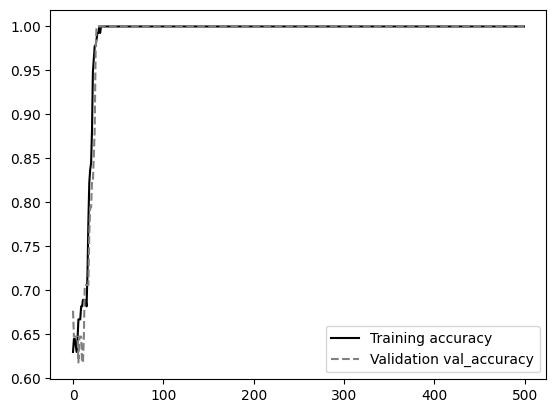

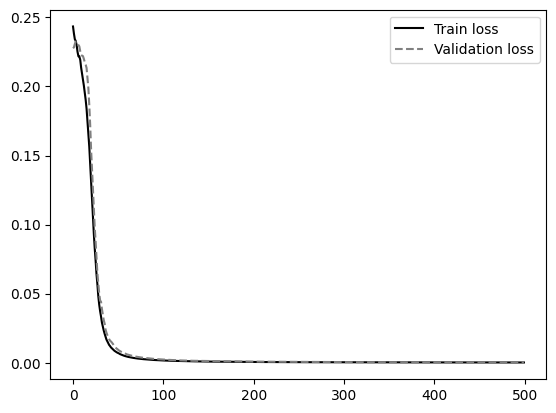

In [11]:
model = grid_search(params, x_train, y_train, k_fold_val)

In [12]:
test_model(model, x_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 2.1796e-04 - accuracy: 1.0000
[0.00021795977954752743, 1.0]


# Monks 3

In [11]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_final": 5,
    "initialization": {
        "type": "default",
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": [0.001, 0.005, 0.01],# np.linspace(0.1, 0.4, 4).tolist(),
    "batch_size": [None],
    "momentum": [0.5, 0.6, 0.7],#np.linspace(0.5, 0.9, 4).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": "l1",
            "value": [0.001]
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}

k_fold_val = {
    "type": "k-fold",
    "n_folds": 4
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [12]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/9:
{'batch_size': None, 'learning_rate': 0.001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

Executing fold 1/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Fold 1/4 median val_loss: 0.2767104506492615, std val_loss 0.0
Fold 1/4 median train_loss: 0.2748316824436188, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.5806451439857483, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.7032967209815979, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.59s/it]


Fold 2/4 median val_loss: 0.3161071538925171, std val_loss 0.0
Fold 2/4 median train_loss: 0.2939649522304535, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.5806451439857483, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.6813187003135681, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.35s/it]


Fold 3/4 median val_loss: 0.2655082643032074, std val_loss 0.0
Fold 3/4 median train_loss: 0.27102234959602356, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.7333333492279053, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.72826087474823, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.22s/it]


Fold 4/4 median val_loss: 0.29140934348106384, std val_loss 0.0
Fold 4/4 median train_loss: 0.29089945554733276, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.6333333253860474, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.6739130616188049, train_accuracy 0.0

Mean val_loss: 0.28743380308151245, std val_loss: 0.01893201987575961
Mean train_loss: 0.28267960995435715, std train_loss: 0.009904626408108333
Mean val_accuracy: 0.6319892406463623, std val_accuracy: 0.06233952885562253
Mean train_accuracy: 0.6319892406463623, std train_accuracy: 0.021186283623490263



Testing configuration 2/9:
{'batch_size': None, 'learning_rate': 0.001, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Fold 1/4 median val_loss: 0.28364065289497375, std val_loss 0.0
Fold 1/4 median train_loss: 0.2824619710445404, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.7252747416496277, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.52s/it]


Fold 2/4 median val_loss: 0.2645239233970642, std val_loss 0.0
Fold 2/4 median train_loss: 0.28671395778656006, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.7419354915618896, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.5824176073074341, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.83s/it]


Fold 3/4 median val_loss: 0.2888808846473694, std val_loss 0.0
Fold 3/4 median train_loss: 0.25747406482696533, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.6666666865348816, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.782608687877655, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Fold 4/4 median val_loss: 0.31636837124824524, std val_loss 0.0
Fold 4/4 median train_loss: 0.3056168258190155, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.5666666626930237, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.5869565010070801, train_accuracy 0.0

Mean val_loss: 0.28835345804691315, std val_loss: 0.018541647678439594
Mean train_loss: 0.2830667048692703, std train_loss: 0.017154877848767826
Mean val_accuracy: 0.6793010830879211, std val_accuracy: 0.07192405523140681
Mean train_accuracy: 0.6793010830879211, std train_accuracy: 0.08703595752622854



Testing configuration 3/9:
{'batch_size': None, 'learning_rate': 0.001, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Fold 1/4 median val_loss: 0.2983701527118683, std val_loss 0.0
Fold 1/4 median train_loss: 0.265646755695343, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.4838709533214569, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.7472527623176575, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 2/4 median val_loss: 0.3232667148113251, std val_loss 0.0
Fold 2/4 median train_loss: 0.26949042081832886, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.4193548262119293, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.7142857313156128, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


Fold 3/4 median val_loss: 0.33378562331199646, std val_loss 0.0
Fold 3/4 median train_loss: 0.3182462751865387, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.5666666626930237, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.44565218687057495, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.52s/it]


Fold 4/4 median val_loss: 0.322677880525589, std val_loss 0.0
Fold 4/4 median train_loss: 0.30506423115730286, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.46666666865348816, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.5652173757553101, train_accuracy 0.0

Mean val_loss: 0.3195250928401947, std val_loss: 0.012988783876236077
Mean train_loss: 0.28961192071437836, std train_loss: 0.022571575302347404
Mean val_accuracy: 0.4841397777199745, std val_accuracy: 0.05318166623062223
Mean train_accuracy: 0.4841397777199745, std train_accuracy: 0.12089970130949551



Testing configuration 4/9:
{'batch_size': None, 'learning_rate': 0.005, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Fold 1/4 median val_loss: 0.21576735377311707, std val_loss 0.0
Fold 1/4 median train_loss: 0.1756860315799713, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.77s/it]


Fold 2/4 median val_loss: 0.21729354560375214, std val_loss 0.0
Fold 2/4 median train_loss: 0.15716560184955597, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


Fold 3/4 median val_loss: 0.18676763772964478, std val_loss 0.0
Fold 3/4 median train_loss: 0.18361900746822357, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9130434989929199, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Fold 4/4 median val_loss: 0.16307684779167175, std val_loss 0.0
Fold 4/4 median train_loss: 0.18025924265384674, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.19572634622454643, std val_loss: 0.02243342527590908
Mean train_loss: 0.1741824708878994, std train_loss: 0.010220199415252205
Mean val_accuracy: 0.893817201256752, std val_accuracy: 0.02570966231255715
Mean train_accuracy: 0.893817201256752, std train_accuracy: 0.015205187053306042



Testing configuration 5/9:
{'batch_size': None, 'learning_rate': 0.005, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 1

100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.56s/it]


Fold 1/4 median val_loss: 0.18024921417236328, std val_loss 0.0
Fold 1/4 median train_loss: 0.15972886979579926, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9032257795333862, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.80s/it]


Fold 2/4 median val_loss: 0.21092930436134338, std val_loss 0.0
Fold 2/4 median train_loss: 0.15862487256526947, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9120879173278809, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.50s/it]


Fold 3/4 median val_loss: 0.2069966197013855, std val_loss 0.0
Fold 3/4 median train_loss: 0.17235712707042694, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.800000011920929, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9021739363670349, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.96s/it]


Fold 4/4 median val_loss: 0.19324439764022827, std val_loss 0.0
Fold 4/4 median train_loss: 0.17237433791160583, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8333333134651184, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9021739363670349, train_accuracy 0.0

Mean val_loss: 0.1978548839688301, std val_loss: 0.012100908994498056
Mean train_loss: 0.16577130183577538, std train_loss: 0.006605974865910508
Mean val_accuracy: 0.8518817126750946, std val_accuracy: 0.03884663385566299
Mean train_accuracy: 0.8518817126750946, std train_accuracy: 0.013023553099242928



Testing configuration 6/9:
{'batch_size': None, 'learning_rate': 0.005, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


Fold 1/4 median val_loss: 0.17574793100357056, std val_loss 0.0
Fold 1/4 median train_loss: 0.13877616822719574, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


Fold 2/4 median val_loss: 0.17552854120731354, std val_loss 0.0
Fold 2/4 median train_loss: 0.15923604369163513, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9677419066429138, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.8901098966598511, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.27s/it]


Fold 3/4 median val_loss: 0.17544150352478027, std val_loss 0.0
Fold 3/4 median train_loss: 0.14008356630802155, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.95652174949646, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.65s/it]


Fold 4/4 median val_loss: 0.16078072786331177, std val_loss 0.0
Fold 4/4 median train_loss: 0.134938046336174, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.17187467589974403, std val_loss: 0.006406067029132601
Mean train_loss: 0.1432584561407566, std train_loss: 0.00941651944261043
Mean val_accuracy: 0.9341397732496262, std val_accuracy: 0.023963962823384
Mean train_accuracy: 0.9341397732496262, std train_accuracy: 0.0241294517046046



Testing configuration 7/9:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}

E

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.98s/it]


Fold 1/4 median val_loss: 0.18434345722198486, std val_loss 0.0
Fold 1/4 median train_loss: 0.1359686553478241, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.91s/it]


Fold 2/4 median val_loss: 0.1391066610813141, std val_loss 0.0
Fold 2/4 median train_loss: 0.13420090079307556, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.87s/it]


Fold 3/4 median val_loss: 0.12177418172359467, std val_loss 0.0
Fold 3/4 median train_loss: 0.13506858050823212, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9239130616188049, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Fold 4/4 median val_loss: 0.1658301204442978, std val_loss 0.0
Fold 4/4 median train_loss: 0.1153358593583107, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.15276360511779785, std val_loss: 0.02405658623132561
Mean train_loss: 0.13014349900186062, std train_loss: 0.008572012240540527
Mean val_accuracy: 0.9344085901975632, std val_accuracy: 0.02359473929073692
Mean train_accuracy: 0.9344085901975632, std train_accuracy: 0.012076134746995372



Testing configuration 8/9:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.6, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.12s/it]


Fold 1/4 median val_loss: 0.1434803307056427, std val_loss 0.0
Fold 1/4 median train_loss: 0.12896127998828888, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9450549483299255, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.89s/it]


Fold 2/4 median val_loss: 0.1708545982837677, std val_loss 0.0
Fold 2/4 median train_loss: 0.11349038779735565, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.8709677457809448, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9560439586639404, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.38s/it]


Fold 3/4 median val_loss: 0.1367647647857666, std val_loss 0.0
Fold 3/4 median train_loss: 0.1241723969578743, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9239130616188049, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.35s/it]


Fold 4/4 median val_loss: 0.12642544507980347, std val_loss 0.0
Fold 4/4 median train_loss: 0.12453074753284454, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.9333333373069763, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.9347826242446899, train_accuracy 0.0

Mean val_loss: 0.14438128471374512, std val_loss: 0.016447428387703817
Mean train_loss: 0.12278870306909084, std train_loss: 0.005690094472140858
Mean val_accuracy: 0.9266128987073898, std val_accuracy: 0.03472946739312421
Mean train_accuracy: 0.9266128987073898, std train_accuracy: 0.011926453375347474



Testing configuration 9/9:
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.47s/it]


Fold 1/4 median val_loss: 0.1243695318698883, std val_loss 0.0
Fold 1/4 median train_loss: 0.1153150424361229, std train_loss 0.0
Fold 1/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 1/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 2/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


Fold 2/4 median val_loss: 0.15879419445991516, std val_loss 0.0
Fold 2/4 median train_loss: 0.11398708075284958, std train_loss 0.0
Fold 2/4 median val_accuracy: 0.9354838728904724, std val_accuracy 0.0
Fold 2/4 median train_accuracy: 0.9340659379959106, train_accuracy 0.0

Executing fold 3/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Fold 3/4 median val_loss: 0.12235131114721298, std val_loss 0.0
Fold 3/4 median train_loss: 0.11625057458877563, std train_loss 0.0
Fold 3/4 median val_accuracy: 0.9666666388511658, std val_accuracy 0.0
Fold 3/4 median train_accuracy: 0.9347826242446899, train_accuracy 0.0

Executing fold 4/4


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.56s/it]


Fold 4/4 median val_loss: 0.14450611174106598, std val_loss 0.0
Fold 4/4 median train_loss: 0.1072961688041687, std train_loss 0.0
Fold 4/4 median val_accuracy: 0.8999999761581421, std val_accuracy 0.0
Fold 4/4 median train_accuracy: 0.945652186870575, train_accuracy 0.0

Mean val_loss: 0.1375052873045206, std val_loss: 0.01503678967463684
Mean train_loss: 0.1132122166454792, std train_loss: 0.0035090430227825054
Mean val_accuracy: 0.9344085901975632, std val_accuracy: 0.02359473929073692
Mean train_accuracy: 0.9344085901975632, std train_accuracy: 0.0049222517459475215






Best configuration (loss 0.1375052873045206):
{'batch_size': None, 'learning_rate': 0.01, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'default'}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_final': 5, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': 'l1', 'value': 0.001}, 'activations_1'

 20%|█████████                                    | 1/5 [00:10<00:42, 10.67s/it]

Trial 1/5 val_mse: 0.10004004836082458
Trial 1/5 train_mse: 0.126214399933815
Trial 1/5 val_accuracy: 0.9599999785423279
Trial 1/5 train_accuracy: 0.9278350472450256


 40%|██████████████████                           | 2/5 [00:24<00:37, 12.46s/it]

Trial 2/5 val_mse: 0.0897088274359703
Trial 2/5 train_mse: 0.12080966681241989
Trial 2/5 val_accuracy: 1.0
Trial 2/5 train_accuracy: 0.9278350472450256


 60%|███████████████████████████                  | 3/5 [00:34<00:22, 11.33s/it]

Trial 3/5 val_mse: 0.10939517617225647
Trial 3/5 train_mse: 0.13377870619297028
Trial 3/5 val_accuracy: 1.0
Trial 3/5 train_accuracy: 0.9175257682800293


 80%|████████████████████████████████████         | 4/5 [00:49<00:12, 12.98s/it]

Trial 4/5 val_mse: 0.08653024584054947
Trial 4/5 train_mse: 0.12040938436985016
Trial 4/5 val_accuracy: 1.0
Trial 4/5 train_accuracy: 0.9175257682800293


100%|█████████████████████████████████████████████| 5/5 [01:04<00:00, 12.91s/it]

Trial 5/5 val_mse: 0.08738550543785095
Trial 5/5 train_mse: 0.12311006337404251
Trial 5/5 val_accuracy: 1.0
Trial 5/5 train_accuracy: 0.9175257682800293

Median val_mse: 0.0897088274359703, std val_mse: 0.008827050264758877
Median train_mse: 0.12080966681241989, std train_mse: 0.004912292279539306
Median val_accuracy: 1.0, std val_accuracy: 0.01600000858306885
Median train_accuracy: 0.9278350472450256, std train_accuracy: 0.0050504946160497815

Median model train_loss: 0.12080966681241989
Median model val_loss: 0.0897088274359703

Median model train_accuracy: 0.9278350472450256
Median model val_accuracy: 1.0


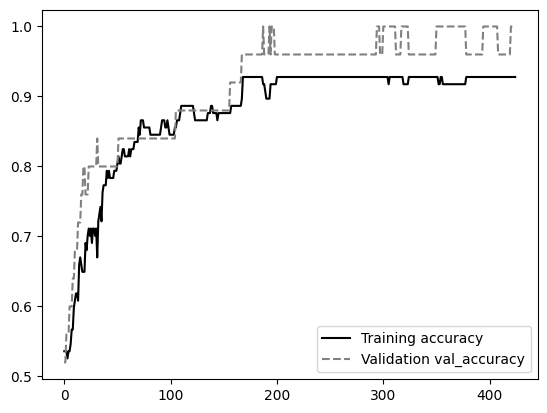

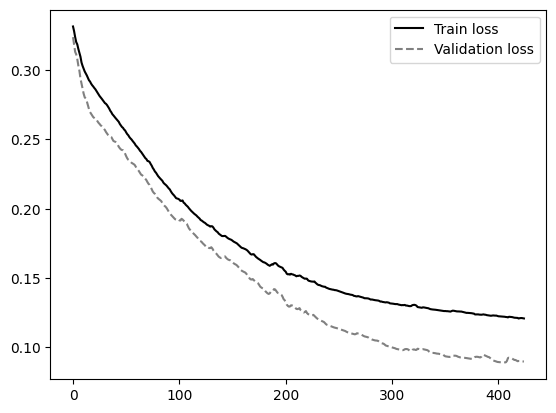

In [13]:
model = grid_search(params, x_train, y_train, k_fold_val)

In [14]:
test_model(model, x_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.1037 - accuracy: 0.9653
[0.10365274548530579, 0.9652777910232544]
